# Face Identification (XGBoost and PCA)

## Load Libraries and Data

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report     
from xgboost import XGBClassifier
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Make this notebook's output stable across runs
random_state = 1000
np.random.seed(random_state)

# Options for plots
%matplotlib inline
sns.set()
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelpad'] = 12

### Data Description

The dataset contains images of faces. The dataset includes a name label for each face.

Source: [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/)

In [2]:
# Load the Labeled Faces in the Wild dataset
lfw = fetch_lfw_people(min_faces_per_person=60)
print(lfw.images.shape)

(1348, 62, 47)


In [3]:
# List the unique names
np.unique(lfw.target_names)

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Junichiro Koizumi',
       'Tony Blair'], dtype='<U17')

In [4]:
# Get counts of each class
np.unique(lfw.target, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([ 77, 236, 121, 530, 109,  71,  60, 144]))

In [5]:
# Shape of each image is 62 x 47, yielding 2,914 pixels
lfw.images[0].shape

(62, 47)

In [6]:
# Print the first two rows of the first image
lfw.images[0][:2, :]

array([[0.53464055, 0.5254902 , 0.49673203, 0.46797386, 0.45228758,
        0.4627451 , 0.4862745 , 0.51633984, 0.5320261 , 0.5555556 ,
        0.5803922 , 0.5895425 , 0.5973856 , 0.6104575 , 0.6379085 ,
        0.64575166, 0.64705884, 0.64575166, 0.6130719 , 0.606536  ,
        0.620915  , 0.627451  , 0.65751636, 0.6470588 , 0.61568624,
        0.6039216 , 0.5895425 , 0.59999996, 0.5908497 , 0.57124186,
        0.5503268 , 0.52287585, 0.5150327 , 0.5019608 , 0.4888889 ,
        0.47843137, 0.4392157 , 0.3934641 , 0.33856213, 0.32156864,
        0.29934642, 0.2784314 , 0.27320263, 0.26928106, 0.2653595 ,
        0.2653595 , 0.26013073],
       [0.56993467, 0.545098  , 0.4797386 , 0.44705883, 0.43398693,
        0.4496732 , 0.4928105 , 0.5398693 , 0.551634  , 0.54640526,
        0.5620915 , 0.57647055, 0.59477127, 0.60915035, 0.6313726 ,
        0.64705884, 0.654902  , 0.66013074, 0.6405229 , 0.61960787,
        0.62352943, 0.63529414, 0.65751636, 0.6405229 , 0.620915  ,
        0.61045

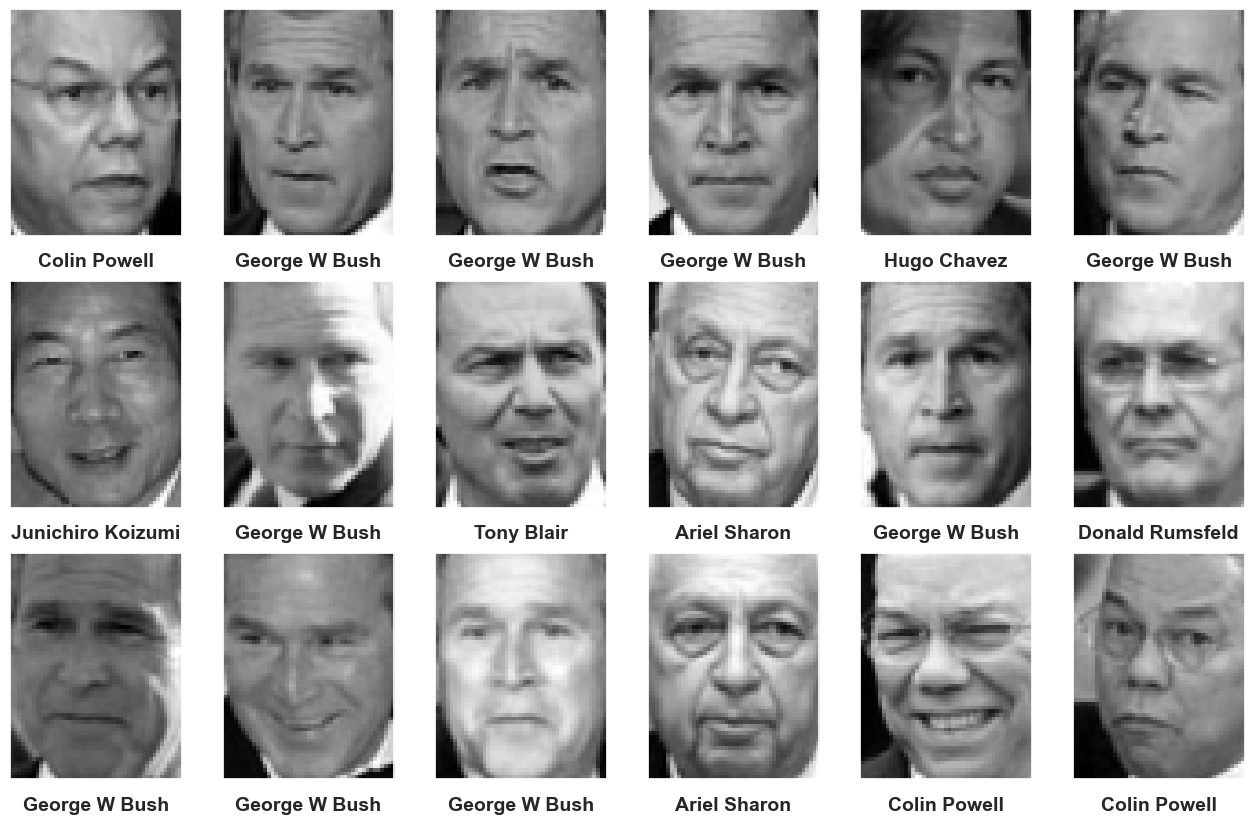

In [7]:
# Display images of first 18 faces
fig, axs = plt.subplots(3, 6, figsize=(16, 10))
for i, ax in enumerate(axs.flat):
    ax.imshow(lfw.images[i], cmap='gray')
    ax.set(xticks=[], yticks=[],
            xlabel=lfw.target_names[lfw.target[i]])

## Model Fitting

In [8]:
# Do a train-test split
y = lfw.target_names[lfw.target]
X = lfw.data

encoder = LabelEncoder()
y = encoder.fit_transform(y)

(X_train, X_test,
 y_train, y_test) = train_test_split(X, y)

In [9]:
# Create an XGBoost classifier
xgbclf = XGBClassifier()

# Fit the XGBoost classifier
xgbclf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [10]:
# Evaluate on test data
y_pred = xgbclf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.21      0.31        19
           1       0.69      0.77      0.72        60
           2       0.64      0.22      0.33        32
           3       0.70      0.96      0.81       133
           4       0.53      0.38      0.44        26
           5       0.71      0.55      0.62        22
           6       0.82      0.75      0.78        12
           7       0.83      0.58      0.68        33

    accuracy                           0.70       337
   macro avg       0.68      0.55      0.59       337
weighted avg       0.69      0.70      0.67       337



## Feature Importances

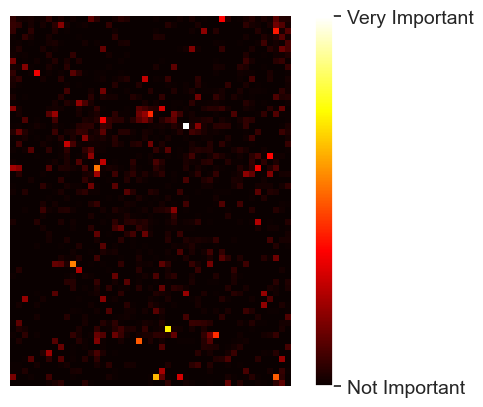

In [11]:
heatmap_image = xgbclf.feature_importances_.reshape(62, 47)
plt.imshow(heatmap_image, cmap='hot')
cbar = plt.colorbar(ticks=[xgbclf.feature_importances_.min(),
                           xgbclf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not Important', 'Very Important'], fontsize=14)
plt.axis('off')
plt.show()

## Reduce Dimensionality

In [12]:
# Scale and center the data prior to applying PCA
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_train_scale[:5]

array([[ 0.07177975, -0.00410597, -0.35032907, ...,  1.2939744 ,
         1.3644154 ,  1.3534234 ],
       [ 1.2276218 ,  1.0914334 ,  1.0802817 , ...,  0.38634303,
        -0.80516165, -1.2276484 ],
       [ 1.6226567 ,  1.3671814 ,  0.8824313 , ..., -1.3035805 ,
        -1.2149228 , -1.1504735 ],
       [-0.22083852, -0.3692857 , -0.16769794, ...,  1.7002476 ,
         1.8086826 ,  1.8850726 ],
       [ 0.2692971 ,  0.14494699,  0.06820081, ..., -0.8454428 ,
        -0.76202893, -0.8031864 ]], dtype=float32)

In [13]:
# Automate selecting dimensions that represent at least 95% of variance
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train_scale)

In [14]:
# Reduced from 2914 features to 178 features
X_train_reduced.shape

(1011, 178)

In [15]:
# Fit XGBoost to reduced data
xgbclf = XGBClassifier()
xgbclf.fit(X_train_reduced, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [16]:
# Evaluate on test data
X_test_scale = scaler.transform(X_test)
X_test_reduced = pca.transform(X_test_scale)
y_pred = xgbclf.predict(X_test_reduced)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.32      0.48        19
           1       0.67      0.75      0.71        60
           2       0.68      0.47      0.56        32
           3       0.70      0.94      0.80       133
           4       0.78      0.54      0.64        26
           5       1.00      0.36      0.53        22
           6       0.67      0.67      0.67        12
           7       0.76      0.58      0.66        33

    accuracy                           0.71       337
   macro avg       0.78      0.58      0.63       337
weighted avg       0.74      0.71      0.69       337



In [17]:
# Use cross-validation to optimize hyperparameters
search_parameters = {
    'learning_rate':np.arange(0.4, 0.7, 0.1),
    'max_depth':np.arange(1, 4),
    'colsample_bytree': np.arange(0.2, 0.5, 0.1)
}

gridclf = GridSearchCV(xgbclf, search_parameters)
gridclf.fit(X_train_reduced, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softprob', predictor=None, ...),
             param_grid={'colsample_bytree': array([0.2, 0.3, 0.4]),
                         'learning_rate': array([0.4, 0.5, 0.6]),
                         'max_depth': array([1, 2, 3])})

In [18]:
# View best parameters
gridclf.best_params_

{'colsample_bytree': 0.30000000000000004, 'learning_rate': 0.5, 'max_depth': 2}

In [19]:
# Evaluate on test data
clf = gridclf.best_estimator_
y_pred = clf.predict(X_test_reduced)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.53      0.65        19
           1       0.70      0.80      0.74        60
           2       0.76      0.50      0.60        32
           3       0.70      0.93      0.80       133
           4       0.80      0.46      0.59        26
           5       1.00      0.32      0.48        22
           6       0.78      0.58      0.67        12
           7       0.81      0.64      0.71        33

    accuracy                           0.73       337
   macro avg       0.80      0.59      0.65       337
weighted avg       0.75      0.73      0.71       337

